In [1]:
import dill

#dill.dump_session('dill_session_data')
dill.load_session('dill_session_data')

In [6]:
# Standard
import math as mt 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import time
import os
import copy

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import random_split
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder

In [5]:
#dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_directory = '/Users/howle/OneDrive/Documents/architecture'

dataset = ImageFolder(data_directory, transform = tt.Compose([tt.Resize(700),
                                                              tt.CenterCrop(600),
                                                              tt.ToTensor()]))


train_size = int(np.ceil(4794*.8))

test_size = int(np.floor(4794*.2))

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=2*32,
    num_workers=1,
    shuffle=True
)

In [3]:
print(f'\nNumber of images in training set: {len(train_ds)}\n')

print(f'Number of images in test set: {len(test_ds)}')


Number of images in training set: 3836

Number of images in test set: 958


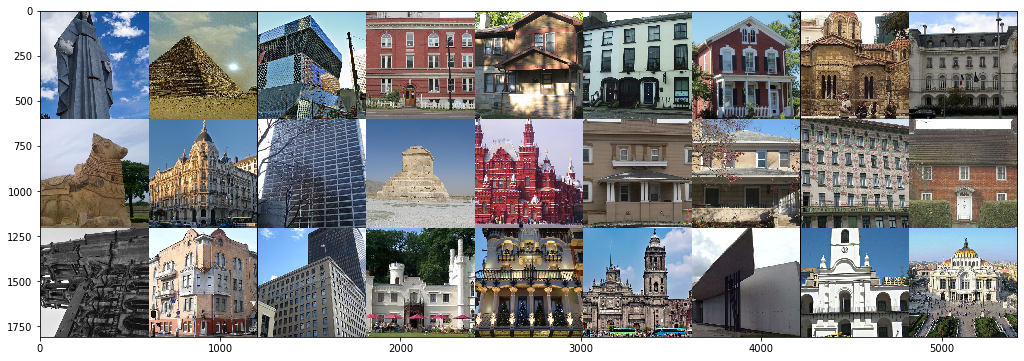

In [6]:
for images, labels in train_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Instantiating Image Classification Framework

In [ ]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Creating the Convolutional Neural Network Class

In [ ]:
class CnnModel(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=1),  # convolutional layer
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),    # convolutional layer 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # outputs 64 x 30 x 30

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),   # convolutional layer 3
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),   # convolutional layer 4
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # outputs 128 x 15 x 15

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),    # convolutional layer 5
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    # convolutional layer 6
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # outputs 256 x 7 x 7

            nn.Flatten(),     # flattening the tensor 
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 25))
        
    def forward(self, xb):
        
        return self.network(xb)

In [ ]:
model = CnnModel()

model

def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item() / len(preds))

for images, labels in train_loader:    
    print(model)
    break

## Instantiating the Evaluation and Fit Functions

In [ ]:
@torch.no_grad()

def evaluate(model, test_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        # training data, evaluating training loss
        model.train()
        train_losses = []
        
        for batch in train_loader:
            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Testing accuracy of predictions
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

## Fitting the Models

In [ ]:
# Parameters

# number of epochs
num_epochs = 20
# learning rate
lr = 0.001

# Adam optimizer
opt_func = torch.optim.Adam

history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

# Transfer Learning

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):
    
    '''
    A function that trains the model and prints out the model accuracy + validation scores at each epoch
    '''
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
train_dataset = train_ds

test_dataset = test_ds

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=2*8,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
# Loading in the Pre-Trained ResNet

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

#  Model Parameters

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)


Epoch 0/2
----------
train Loss: 1.8390 Acc: 0.4601
val Loss: 1.1149 Acc: 0.6628

Epoch 1/2
----------
train Loss: 1.0115 Acc: 0.6966
val Loss: 0.9160 Acc: 0.7223

Epoch 2/2
----------
train Loss: 0.6675 Acc: 0.8014
val Loss: 0.8391 Acc: 0.7599

Training complete in 5m 39s
Best val Acc: 0.759916


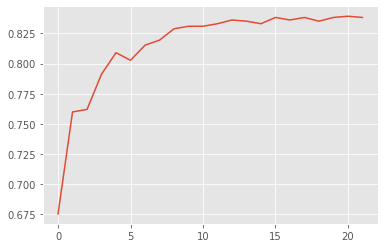

In [8]:
plt.style.use('ggplot')


epoc_list = [*range(0, 22, 1)]

val_list = [0.6754, 0.7599, 0.7620, 0.7912, 0.8090, 0.8027, 
           0.8152, 0.8194, 0.8288, 0.8309, 0.8309, 0.8330,
           0.8361, 0.8351, 0.8330, 0.8382, 0.8361, 0.8382,
           0.8351, 0.8382, 0.8392, 0.8382]

train_list = [0.4690, 0.6947, 0.7943, 0.8749, 0.9333, 0.9630,
              0.9807, 0.9906, 0.9930, 0.9950, 0.9948, 0.9958,
              0.9953, 0.9953, 0.9979, 0.9956, 0.9984, 0.9964,
              0.9974, 0.9971, 0.9977, 0.9966]

plt.plot(epoc_list, val_list)

In [21]:
batch_size_list = [8, 16, 32]
optimizer_list = ['adam', 'sgd']
lr_list = [0.0001, 0.001, 0.01]

In [29]:
model_dict = {}

i = 0

for batch in batch_size_list:
    for optimizer in optimizer_list:
        for lr in lr_list:
            model_dict[i] = [batch, optimizer, lr]
            i += 1
            
model_dict

model_dict[0].append([1, 2, 3, 4, 5])

model_dict

{0: [8, 'adam', 0.0001, [1, 2, 3, 4, 5]],
 1: [8, 'adam', 0.001],
 2: [8, 'adam', 0.01],
 3: [8, 'sgd', 0.0001],
 4: [8, 'sgd', 0.001],
 5: [8, 'sgd', 0.01],
 6: [16, 'adam', 0.0001],
 7: [16, 'adam', 0.001],
 8: [16, 'adam', 0.01],
 9: [16, 'sgd', 0.0001],
 10: [16, 'sgd', 0.001],
 11: [16, 'sgd', 0.01],
 12: [32, 'adam', 0.0001],
 13: [32, 'adam', 0.001],
 14: [32, 'adam', 0.01],
 15: [32, 'sgd', 0.0001],
 16: [32, 'sgd', 0.001],
 17: [32, 'sgd', 0.01]}

In [67]:
model_dict = {}
i = 0

batch_size_list = [8, 16, 32]
optimizer_list = ['sgd', 'adam']
lr_list = [0.01, 0.0001, 0.00001]


for batch in batch_size_list:
    
    for optimizer in optimizer_list:
        
        for lr in lr_list:
            
            model_dict[i] = [batch, optimizer, lr]

            def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):

                '''
                A function that trains the model and prints out the model accuracy + validation scores at each epoch
                '''

                global model_dict

                val_acc_list = []

                since = time.time()

                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = 0.0

                for epoch in range(num_epochs):
                    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                    print('-' * 10)

                    for phase in ['train', 'val']:
                        if phase == 'train':
                            model.train()  
                        else:
                            model.eval()   

                        running_loss = 0.0
                        running_corrects = 0

                        # Iterate over data
                        for inputs, labels in dataloaders[phase]:
                            inputs = inputs.to(device)
                            labels = labels.to(device)

                            optimizer.zero_grad()

                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                        if phase == 'train':
                            scheduler.step()

                        epoch_loss = running_loss / dataset_sizes[phase]
                        epoch_acc = running_corrects.double() / dataset_sizes[phase]

                        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                            phase, epoch_loss, epoch_acc))

                        if phase == 'val':
                            val_acc_list.append(float(epoch_acc.cpu().detach().numpy()))

                        if phase == 'val' and epoch_acc > best_acc:
                            best_acc = epoch_acc
                            best_model_wts = copy.deepcopy(model.state_dict())

                    print()

                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                model_dict[i].append(val_acc_list)

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model




            train_loader = DataLoader(
                train_ds,
                batch_size=batch,
                num_workers=1,
                shuffle=True
            )

            test_loader = DataLoader(
                test_ds,
                batch_size=2*batch,
                num_workers=1,
                shuffle=True
            )


            # Loading in the Pre-Trained ResNet

            model_ft = models.resnet34(pretrained=True)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, 25)

            #  Model Parameters

            model_ft = model_ft.to(device)

            criterion = nn.CrossEntropyLoss()
            
            if optimizer == 'adam':
                optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)
            
            if optimizer == 'sgd':
                optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

            exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

            model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                   num_epochs=8)
            
            i += 1

Epoch 0/7
----------
train Loss: 2.4840 Acc: 0.3092
val Loss: 1.9156 Acc: 0.4186

Epoch 1/7
----------
train Loss: 1.6778 Acc: 0.4901
val Loss: 1.9289 Acc: 0.4979

Epoch 2/7
----------
train Loss: 1.3608 Acc: 0.5850
val Loss: 1.4174 Acc: 0.5772

Epoch 3/7
----------
train Loss: 1.1013 Acc: 0.6556
val Loss: 1.3760 Acc: 0.6075

Epoch 4/7
----------
train Loss: 0.9444 Acc: 0.7067
val Loss: 1.4185 Acc: 0.6284

Epoch 5/7
----------
train Loss: 0.8243 Acc: 0.7479
val Loss: 1.2448 Acc: 0.6712

Epoch 6/7
----------
train Loss: 0.6877 Acc: 0.7774
val Loss: 1.3826 Acc: 0.6639

Epoch 7/7
----------
train Loss: 0.3114 Acc: 0.8962
val Loss: 0.9035 Acc: 0.7881

Training complete in 15m 24s
Best val Acc: 0.788100
Epoch 0/7
----------
train Loss: 2.7833 Acc: 0.2331
val Loss: 2.3874 Acc: 0.3674

Epoch 1/7
----------
train Loss: 2.1878 Acc: 0.4194
val Loss: 1.8750 Acc: 0.4958

Epoch 2/7
----------
train Loss: 1.8199 Acc: 0.5193
val Loss: 1.5963 Acc: 0.5637

Epoch 3/7
----------
train Loss: 1.5852 Acc: 0

In [2]:
model_dict

{0: [8,
  'sgd',
  0.01,
  [0.418580375782881,
   0.49791231732776614,
   0.5772442588726513,
   0.6075156576200417,
   0.6283924843423799,
   0.6711899791231732,
   0.6638830897703548,
   0.7881002087682671]],
 1: [8,
  'sgd',
  0.0001,
  [0.36743215031315235,
   0.49582463465553234,
   0.5636743215031315,
   0.5939457202505218,
   0.6325678496868475,
   0.6492693110647181,
   0.673277661795407,
   0.6784968684759916]],
 2: [8,
  'sgd',
  1e-05,
  [0.18371607515657618,
   0.22129436325678495,
   0.23590814196242169,
   0.2651356993736952,
   0.28183716075156573,
   0.30167014613778703,
   0.33507306889352817,
   0.3329853862212943]],
 3: [8,
  'adam',
  0.01,
  [0.092901878914405,
   0.14196242171189977,
   0.1346555323590814,
   0.12004175365344466,
   0.14091858037578286,
   0.22755741127348642,
   0.22755741127348642,
   0.31315240083507306]],
 4: [8,
  'adam',
  0.0001,
  [0.6398747390396659,
   0.7599164926931106,
   0.7296450939457202,
   0.7818371607515657,
   0.749478079331941

### Showing Adam vs SGD

Text(0.5, 1.0, 'Adam vs SGD Validation Accuracy')

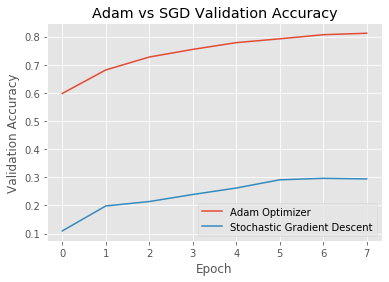

In [2]:
best = model_dict[17]
sgd_compare = model_dict[14]
epoc_list = [*range(0, 8, 1)]

plt.style.use('ggplot')
plt.plot(epoc_list, best[3], label= "Adam Optimizer")
plt.plot(epoc_list, sgd_compare[3], label= "Stochastic Gradient Descent")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Adam vs SGD Validation Accuracy")

### Learning Rate

Text(0.5, 1.0, 'Learning Rates')

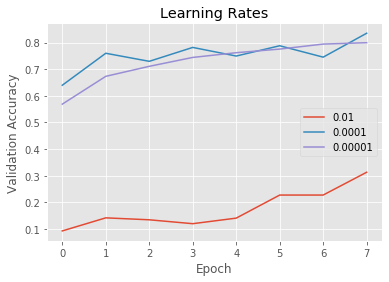

In [8]:
large = model_dict[3]
med = model_dict[4]
small = model_dict[5]

epoc_list = [*range(0, 8, 1)]

plt.style.use('ggplot')
plt.plot(epoc_list, large[3], label= "0.01")
plt.plot(epoc_list, med[3], label= "0.0001")
plt.plot(epoc_list, small[3], label= "0.00001")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Learning Rates")

### Batch Size

Text(0.5, 1.0, 'Batch Size')

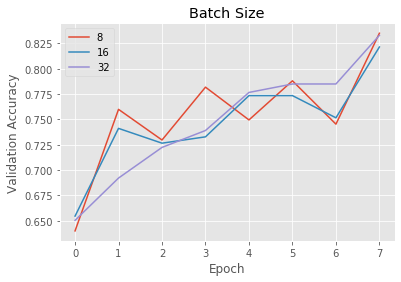

In [9]:
eight = model_dict[4]
sixteen = model_dict[10]
thirty_two = model_dict[16]

epoc_list = [*range(0, 8, 1)]

plt.style.use('ggplot')
plt.plot(epoc_list, eight[3], label= "8")
plt.plot(epoc_list, sixteen[3], label= "16")
plt.plot(epoc_list, thirty_two[3], label= "32")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Batch Size")

## Normalization

In [8]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

In [34]:
#dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_directory = '/Users/howle/OneDrive/Documents/architecture'

dataset = ImageFolder(data_directory, transform = tt.Compose([tt.Resize(700),
                                                              tt.CenterCrop(600),
                                                              tt.ToTensor(),
                                                              tt.Normalize(means, stds)]))


train_size = int(np.ceil(4794*.8))

test_size = int(np.floor(4794*.2))

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=2*32,
    num_workers=1,
    shuffle=True
)

In [35]:
print(f'\nNumber of images in training set: {len(train_ds)}\n')

print(f'Number of images in test set: {len(test_ds)}')


Number of images in training set: 3836

Number of images in test set: 958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


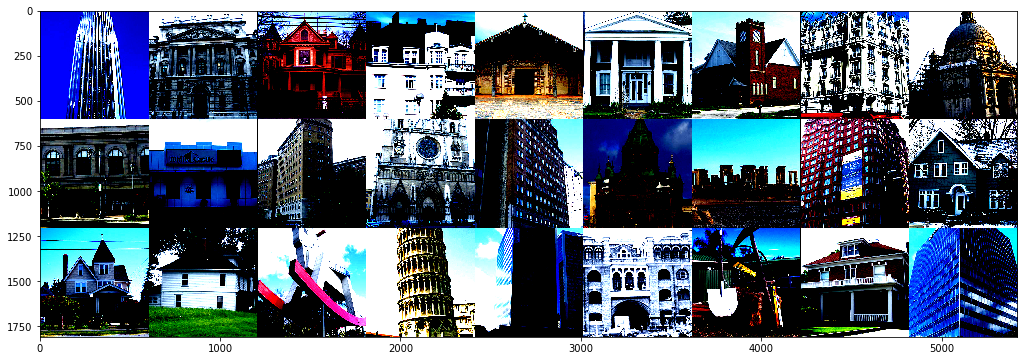

In [11]:
for images, labels in train_loader:
    break
im = make_grid(images[0:27], nrow= 9) 
plt.figure(figsize=(20,6))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Running Best Hyperparameters on Normalized Images

In [36]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    
    '''
    A function that trains the model and prints out the model accuracy + validation scores at each epoch
    '''
    
    global train_loss_list
    global val_loss_list
    global train_acc_list
    global val_acc_list
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)              

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
train_dataset = train_ds

test_dataset = test_ds

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=2*32,
    num_workers=1,
    shuffle=True
)

image_datasets = {}
image_datasets['train'] = train_dataset
image_datasets['val'] = test_dataset

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = test_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# Loading in the Pre-Trained ResNet

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

#  Model Parameters

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 2.6865 Acc: 0.2633
val Loss: 2.0806 Acc: 0.4656

Epoch 1/24
----------
train Loss: 1.7857 Acc: 0.5579
val Loss: 1.5205 Acc: 0.6180

Epoch 2/24
----------
train Loss: 1.3811 Acc: 0.6635
val Loss: 1.2515 Acc: 0.6649

Epoch 3/24
----------
train Loss: 1.1236 Acc: 0.7245
val Loss: 1.0873 Acc: 0.7067

Epoch 4/24
----------
train Loss: 0.9361 Acc: 0.7735
val Loss: 0.9795 Acc: 0.7328

Epoch 5/24
----------
train Loss: 0.7856 Acc: 0.8186
val Loss: 0.8936 Acc: 0.7589

Epoch 6/24
----------
train Loss: 0.6556 Acc: 0.8530
val Loss: 0.8320 Acc: 0.7683

Epoch 7/24
----------
train Loss: 0.5598 Acc: 0.8811
val Loss: 0.8185 Acc: 0.7724

Epoch 8/24
----------
train Loss: 0.5386 Acc: 0.8910
val Loss: 0.8182 Acc: 0.7777

Epoch 9/24
----------
train Loss: 0.5357 Acc: 0.8910
val Loss: 0.8164 Acc: 0.7808

Epoch 10/24
----------
train Loss: 0.5186 Acc: 0.8942
val Loss: 0.8065 Acc: 0.7777

Epoch 11/24
----------
train Loss: 0.5020 Acc: 0.9038
val Loss: 0.8018 Acc: 0.7797

Ep

In [ ]:
train_acc_list
val_acc_list

### Model Performance on Normalized Images

Text(0.5, 1.0, 'Model Loss')

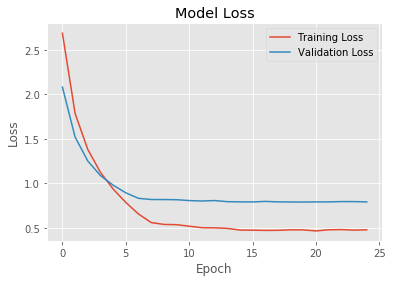

In [27]:
epochs = [*range(0, 25, 1)]

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, val_loss_list, label= "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

In [29]:
train_acc_list2 = []
val_acc_list2 = []

for i in train_acc_list:
    train_acc_list2.append(float(i.cpu().detach().numpy()))
    
for i in val_acc_list:
    val_acc_list2.append(float(i.cpu().detach().numpy()))

Text(0.5, 1.0, 'Model Prediction Accuracy')

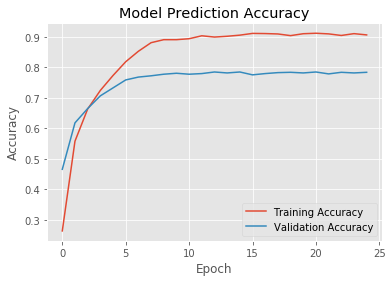

In [30]:
plt.style.use('ggplot')
plt.plot(epochs, train_acc_list2, label='Training Accuracy')
plt.plot(epochs, val_acc_list2, label= "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Prediction Accuracy")

## Fine-tuning Parameters

# Final, Best CNN Model

In [39]:
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    num_workers=1,
    shuffle=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=2*8,
    num_workers=1,
    shuffle=True
)


train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Loading in the Pre-Trained ResNet

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

#  Model Parameters

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4506 Acc: 0.6006
val Loss: 0.9240 Acc: 0.7265

Epoch 1/24
----------
train Loss: 0.6464 Acc: 0.8209
val Loss: 0.7565 Acc: 0.7797

Epoch 2/24
----------
train Loss: 0.3034 Acc: 0.9317
val Loss: 0.7197 Acc: 0.7912

Epoch 3/24
----------
train Loss: 0.1385 Acc: 0.9771
val Loss: 0.7111 Acc: 0.8079

Epoch 4/24
----------
train Loss: 0.0718 Acc: 0.9888
val Loss: 0.7058 Acc: 0.7975

Epoch 5/24
----------
train Loss: 0.0356 Acc: 0.9971
val Loss: 0.6419 Acc: 0.8267

Epoch 6/24
----------
train Loss: 0.0202 Acc: 0.9977
val Loss: 0.6388 Acc: 0.8351

Epoch 7/24
----------
train Loss: 0.0136 Acc: 0.9982
val Loss: 0.5940 Acc: 0.8455

Epoch 8/24
----------
train Loss: 0.0106 Acc: 0.9992
val Loss: 0.5885 Acc: 0.8466

Epoch 9/24
----------
train Loss: 0.0093 Acc: 0.9992
val Loss: 0.5966 Acc: 0.8434

Epoch 10/24
----------
train Loss: 0.0081 Acc: 0.9992
val Loss: 0.5930 Acc: 0.8507

Epoch 11/24
----------
train Loss: 0.0081 Acc: 0.9992
val Loss: 0.5913 Acc: 0.8539

Ep

Text(0.5, 1.0, 'Model Loss')

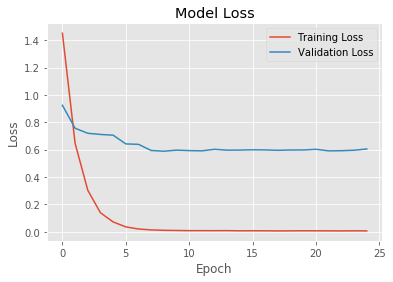

In [41]:
epochs = [*range(0, 25, 1)]

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, val_loss_list, label= "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")

In [42]:
train_acc_list2 = []
val_acc_list2 = []

for i in train_acc_list:
    train_acc_list2.append(float(i.cpu().detach().numpy()))
    
for i in val_acc_list:
    val_acc_list2.append(float(i.cpu().detach().numpy()))

Text(0.5, 1.0, 'Model Prediction Accuracy')

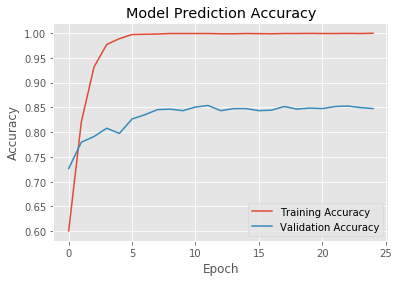

In [43]:
plt.style.use('ggplot')
plt.plot(epochs, train_acc_list2, label='Training Accuracy')
plt.plot(epochs, val_acc_list2, label= "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Prediction Accuracy")

# Support Vector Machines

### Loading data

In [12]:
data_directory = '/Users/howle/OneDrive/Documents/architecture'

dataset = ImageFolder(data_directory, transform = tt.Compose([tt.Resize(28),
                                                              tt.CenterCrop(28),
                                                              tt.ToTensor()]))


train_size = int(np.ceil(4794*.8))

test_size = int(np.floor(4794*.2))

train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_dataset = train_ds
test_dataset = test_ds

In [13]:
for n, i in enumerate(train_dataset):
    break
    
len(np.array(i[0].reshape(-1)))

2352

In [14]:
d = {}

for n, i in (enumerate(train_dataset)):
    
    np_im = list(np.array(i[0]).reshape(-1))
    np_im.insert(0, i[1])
    d[n] = np_im
    
df = pd.DataFrame.from_dict(d, 'index')
    
df = df.rename(columns={0: 'label'})

train_df = df

train_df

d = {}

for n, i in (enumerate(test_dataset)):
    
    np_im = list(np.array(i[0]).reshape(-1))
    np_im.insert(0, i[1])
    d[n] = np_im
    
df = pd.DataFrame.from_dict(d, 'index')
    
df = df.rename(columns={0: 'label'})

test_df = df


x_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]

x_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

### training sample

In [15]:
# sample_df = train_df.sample(n=1500, replace = False)
sample_df = train_df

x_train = sample_df.iloc[:,1:]
y_train = sample_df.iloc[:,0]

### Parameter Tuning Lists

In [18]:
c_list = [0.1]
gamma_list = [0.1, 'auto', 'scale']
class_weight_list = [None]
degrees = [1, 2, 3]

## Training and Validating 9 Models using 5-Fold CV

In [19]:
best_cv = 0
best_c = 0
best_gamma = 0
best_class_weight = 0
best_n_features = 0
iters = 1
best_degree = 0

print("All SVM Radial Kernal Models:")

for c_val in c_list:
    
    for gamma_val in gamma_list:

      for class_weight_val in class_weight_list:
        
        for degree in degrees:

            model = svm.SVC(kernel='poly', C=c_val, gamma=gamma_val, class_weight =class_weight_val, degree = degree).fit(x_train,y_train)

            cvs = cross_val_score(model, x_train, y_train, cv = 5)

            cv = sum(cvs)/len(cvs)
            print(f'Degree: {degree}    C: {c_val}    Gamma: {gamma_val}    Class Weight: {class_weight_val}    5-Fold CV Score: {cv}')

            if cv > best_cv:
                best_cv = cv
                best_c = c_val
                best_class_value = class_weight_val
                best_gamma = gamma_val
                best_degree = degree

            iters += 1
            

All SVM Radial Kernal Models:
Degree: 1    C: 0.1    Gamma: 0.1    Class Weight: None    5-Fold CV Score: 0.2544376086484137
Degree: 2    C: 0.1    Gamma: 0.1    Class Weight: None    5-Fold CV Score: 0.26199546392872664
Degree: 3    C: 0.1    Gamma: 0.1    Class Weight: None    5-Fold CV Score: 0.26460506301608
Degree: 1    C: 0.1    Gamma: auto    Class Weight: None    5-Fold CV Score: 0.09332627118644068
Degree: 2    C: 0.1    Gamma: auto    Class Weight: None    5-Fold CV Score: 0.09332627118644068
Degree: 3    C: 0.1    Gamma: auto    Class Weight: None    5-Fold CV Score: 0.09332627118644068
Degree: 1    C: 0.1    Gamma: scale    Class Weight: None    5-Fold CV Score: 0.18273984137331595
Degree: 2    C: 0.1    Gamma: scale    Class Weight: None    5-Fold CV Score: 0.2557356176662321
Degree: 3    C: 0.1    Gamma: scale    Class Weight: None    5-Fold CV Score: 0.28311094361147326


In [20]:
print(f'The best performing Support Vector Machine with radial kernel, model used {best_c} C value, \nhad a gamma of {best_gamma}, \n\
had a class weight of {best_class_weight}, \n\
and had a degree of {best_degree}. \n\
This model had a cross validation score of {round((100*best_cv), 2)}%')

The best performing Support Vector Machine with radial kernel, model used 0.1 C value, 
had a gamma of scale, 
had a class weight of 0, 
and had a degree of 3. 
This model had a cross validation score of 28.31%


## Testing Model Predictions on Validation set

In [22]:
x_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,0]

x_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]

model = svm.SVC(kernel='poly', C= 0.1, gamma='scale', class_weight =None, degree=3).fit(x_train,y_train)

predictions = model.predict(x_test)

score = round((100*accuracy_score(y_test, predictions)), 2)

print(f'The model classified architecture with a validation accuracy of: {score}%')

The model classified architecture with a validation accuracy of: 29.65%
